In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#import h5py
import scipy.io

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
print(torch.__version__)

1.8.1


In [3]:
#f = h5py.File('somefile.mat','r')
matdata=scipy.io.loadmat('dataForPythonBIMcmplx25dB.mat')

In [4]:
Hatm=matdata['Hatm']
Atm=matdata['Atm']
N=int((matdata['N']))
targetsR=matdata['d_epsaM']
targetsI=np.zeros_like(targetsR)
nMeas=int((matdata['nMeas']))
nRx=int((matdata['nRx']))
nTx=int((matdata['nTx']))
Np=int((matdata['Np']))
Emea=matdata['Emea']
Einc=matdata['Ez_inc']
#a1tm=matdata['a1tm']
#a1tmC=matdata['a1tmC']

In [5]:
targets=np.concatenate((targetsR,targetsI),axis=1)
targets.shape

(70000, 4608)

In [6]:
inputs=Emea
Emea.shape

(70000, 28, 16)

In [7]:
inputs=torch.tensor(inputs,dtype = torch.complex64)
targets=torch.tensor(targets,dtype = torch.float32)
Hatm=torch.tensor(Hatm,dtype = torch.complex64)
Atm=torch.tensor(Atm,dtype = torch.complex128)
Einc=torch.tensor(Einc,dtype = torch.complex128)
#a1tm=torch.tensor(a1tm,dtype = torch.complex64)
#a1tmC=torch.tensor(a1tmC,dtype = torch.complex64)

In [8]:
a1tm=Atm[0,:].reshape(Np,Np)
a1tm=torch.cat((a1tm[range(Np-1,-1,-1),:],a1tm[range(1,Np,1),:]),dim=0)
a1tm=torch.cat((a1tm[:,range(Np-1,-1,-1)],a1tm[:,range(1,Np,1)]),dim=1)
a1tmC=torch.fft.fft2(a1tm)

In [9]:
valSize=2000
testingSize=2000
trainingSize=len(inputs)-(valSize+testingSize)
train_in, val_in, test_in = torch.split(inputs, [trainingSize, valSize, testingSize])
train_tr, val_tr, test_tr = torch.split(targets, [trainingSize, valSize, testingSize])
train_ds = TensorDataset(train_in, train_tr)
val_ds = TensorDataset(val_in, val_tr)
test_ds = TensorDataset(test_in, test_tr)

In [10]:
#print(len(dataset[0:10]))
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

66000
2000
2000


In [11]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size, shuffle=True)

In [12]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cpu')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
Hatm=to_device(Hatm, device)
Atm=to_device(Atm, device)
Einc=to_device(Einc, device)
a1tm=to_device(a1tm, device)
a1tmC=to_device(a1tmC, device)
inputs=to_device(inputs, device)
targets=to_device(targets, device)

In [15]:
class ImageRegressionBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                  # Generate predictions
        loss = F.mse_loss(out, targets) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                    # Generate predictions
        loss = F.mse_loss(out, targets)   # Calculate loss
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))

In [16]:
negSlop=0.1
def conv_block(in_channels, out_channels):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.LeakyReLU(negSlop,inplace=True),
              nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1), 
              nn.LeakyReLU(negSlop,inplace=True)]
    return nn.Sequential(*layers)

def conv_block_downsampling(in_channels, out_channels):
    layers=nn.ModuleList()
    layers.append(nn.MaxPool2d(2, stride=2))
    layers.append(conv_block(in_channels, out_channels))
    return nn.Sequential(*layers)

def conv_block_upsampling(in_channels, out_channels):
    layers=nn.ModuleList()
    layers.append(conv_block(2*in_channels, in_channels))
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, bias=False))
    layers.append(nn.LeakyReLU(negSlop,inplace=True))
    return nn.Sequential(*layers)

def conv_block_upsamplingF(in_channels, out_channels):
    layers=nn.ModuleList()
    layers.append(conv_block(2*in_channels, in_channels))
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
    layers.append(nn.LeakyReLU(negSlop,inplace=True))
    return nn.Sequential(*layers)

Nfltr=32
class Unet(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.in_channels=in_channels
        self.down1 = conv_block(in_channels,Nfltr) #conv_block_downsampling(in_channels, 64,pool=False)
        self.down2 = conv_block_downsampling(Nfltr, 2*Nfltr)
        self.down3 = conv_block_downsampling(2*Nfltr,4*Nfltr)
        self.down4 = nn.ModuleList()
        self.down4.append(conv_block_downsampling(4*Nfltr, 8*Nfltr))
        self.down4.append(nn.ConvTranspose2d(8*Nfltr, 4*Nfltr, kernel_size=2, stride=2, bias=False))
        self.down4.append(nn.LeakyReLU(negSlop,inplace=True))
        self.down4=nn.Sequential(*self.down4)
        
        self.up1=conv_block_upsampling(4*Nfltr, 2*Nfltr)
        self.up2=conv_block_upsampling(2*Nfltr, Nfltr)
        self.up3=conv_block_upsamplingF(Nfltr, in_channels)
        
    def forward(self, d_epsR,d_epsI):
        xb=torch.cat((d_epsR,d_epsI),dim=1)
        xb=torch.reshape(xb,(-1,self.in_channels,Np,Np))
        out1 = self.down1(xb)
        out2=self.down2(out1)
        out3=self.down3(out2)
        out4=self.down4(out3)
        out5=self.up1(torch.cat((out3,out4),dim=1))
        out6=self.up2(torch.cat((out2,out5),dim=1))
        out7=self.up3(torch.cat((out1,out6),dim=1))
        out=torch.reshape(out7,(-1,self.in_channels*N))
        return out[:,0:N], out[:,N:2*N]

In [20]:
def HmatMult(Etot,d_eps):
    nbatch=d_eps.shape[1]
    xout=to_device(torch.zeros((nRx,nbatch,nTx),dtype=torch.complex64), device)
    temp=to_device(torch.zeros((N,nbatch),dtype=torch.complex64), device)
    for tr in range(nTx):
        temp=Etot[:,:,tr]*d_eps
        xout[:,:,tr]=Hatm@temp
    return -xout

def HmatconjMult(Etot,xin):
    nbatch=xin.shape[1]
    xout=to_device(torch.zeros((N,nbatch)), device)
    for tr in range(nTx):
        xout=xout+Etot[:,:,tr].conj()*(Hatm.t().conj()@xin[:,:,tr])
    return -xout


def soft_thresholding(d_eps,delta):
    nbatch=d_eps.shape[1]
    maxi=torch.zeros_like(d_eps)
    maxi=torch.maximum(d_eps.abs()-delta,torch.zeros_like(d_eps.real))
    d_eps=(maxi*d_eps)/(maxi+delta);
    return d_eps

  

def BiCGFFTtm(d_eps,y,nmax):
    y=torch.reshape(y,(N,1))
    nbatch=d_eps.shape[1]
    xout=to_device(torch.zeros((N,nbatch),dtype= torch.complex64), device)
    if torch.sum(torch.abs(d_eps))<=0.0000000000001:
        temp=to_device(torch.zeros((N,nbatch),dtype= torch.complex64), device)
        xout=y-temp
        del temp
    else:
        rhoi=1.0*to_device(torch.ones((nbatch),dtype= torch.complex128), device)
        alpha=1.0*to_device(torch.ones((nbatch),dtype= torch.complex128), device)
        w=1.0*to_device(torch.ones((nbatch),dtype= torch.complex128), device)
        v=to_device(torch.zeros((N,nbatch),dtype= torch.complex128), device)
        p=to_device(torch.zeros((N,nbatch),dtype= torch.complex128), device)
        x=to_device(torch.zeros((N,nbatch),dtype= torch.complex128), device)
        temp=to_device(torch.zeros((N,nbatch)), device)
        temp=AmultFFT(d_eps,x)
        r=y-temp
        rhat0=r
        for cg_iter in range(nmax):
            rhoi_1=rhoi
            rhoi=torch.sum(rhat0*r,dim=0)
            beta=(rhoi/rhoi_1)*(alpha/w)
            p=r+beta*(p-w*v)
            v=AmultFFT(d_eps,p)
            alpha=rhoi/(torch.sum(rhat0*v,dim=0))
            s=r-alpha*v
            t=AmultFFT(d_eps,s)
            w=(torch.sum(t*s,dim=0))/(torch.sum(t*t,dim=0))
            x=x+alpha*p+w*s
            r=s-w*t
        xout=x
    return xout  



def AmultFFT(deps,xi):
    xi=xi.permute(1,0)
    deps=deps.permute(1,0)
    nbatch=deps.shape[0]
    x=to_device(torch.zeros((nbatch,2*Np-1,2*Np-1),dtype=torch.complex128),device)
    x[:,0:Np,0:Np]=torch.reshape(deps*xi,(-1,Np,Np))
    xfft=torch.fft.fft2(x)
    x=a1tmC*xfft
    out=torch.fft.ifft2(x)
    out=out[:,Np-1:2*Np-1,Np-1:2*Np-1]
    out=out.reshape(nbatch,N)
    out=out+xi
    return out.permute(1,0)

def BiCGtmFFTloop(d_eps,Einc,nmax):
    nbatch=d_eps.shape[1]
    Etot=to_device(torch.zeros((N,nbatch,nTx),dtype= torch.complex64), device)
    for tr in range(nTx):
        Etot[:,:,tr]=BiCGFFTtm(d_eps,Einc[:,tr],nmax)
    return Etot


def power(Etot,maxit):
    nbatch=Etot.shape[1]
    x=to_device(torch.rand((N,nbatch),dtype= torch.complex64), device)
    xn=to_device(torch.zeros((N,nbatch),dtype= torch.complex64), device)
    xm=to_device(torch.zeros((N,nbatch),dtype= torch.complex64), device)
    xm = HmatMult(Etot,x)
    xn = HmatconjMult(Etot,xm)
    lammda=torch.sum(x*xn,dim=0)/torch.sum(x*x,dim=0)
    x=x/torch.max(x.abs(),dim=0).values
    for itr in range(maxit):
        xm = HmatMult(Etot,x)
        x = HmatconjMult(Etot,xm)
        xm = HmatMult(Etot,x)
        xn = HmatconjMult(Etot,xm)
        lammda0=lammda
        lammda=torch.sum(x*xn,dim=0)/torch.sum(x*x,dim=0)
        x=x/torch.max(x.abs(),dim=0).values
        error=torch.abs(lammda-lammda0)/torch.abs(lammda)
    return 1/lammda.real

    
class ComputeBornSVD(ImageRegressionBase):
    def __init__(self,regNet1,regNet2,regNet3,nLW,nbim_iter,nmax,maxit):
        super().__init__()
        self.regNet1=regNet1
        self.regNet2=regNet2
        self.regNet3=regNet3
        self.nLW=nLW
        self.nbim_iter=nbim_iter
        self.nmax=nmax
        self.maxit=maxit
        Etot=to_device(torch.zeros((N,1,nTx),dtype= torch.complex64), device)
        Etot[:,0,:]=Einc[:,:]
        self.gamma0=power(Etot,maxit)
        print(self.gamma0)
        
    def forward(self, Emea):
        nbatch=Emea.shape[0]
        d_eps=to_device(torch.zeros((N,nbatch),dtype= torch.complex64), device)
        Etot=to_device(torch.zeros((N,nbatch,nTx),dtype= torch.complex64), device)

        for batch in range(nbatch):
            Etot[:,batch,:]=Einc[:,:]
        
        for bim_itr in range(self.nbim_iter):
            if bim_itr==0:
                gamma=self.gamma0
            else:
                gamma=power(Etot,self.maxit)  
        
            for lw_itr in range(self.nLW):
                xout = HmatMult(Etot,d_eps)
                misfit=Emea.permute(1,0,2)-xout
                xout = HmatconjMult(Etot,misfit)
                d_eps=d_eps+gamma*xout
                if bim_itr==0:
                    d_epsR,d_epsI=self.regNet1(d_eps.permute(1,0).real,d_eps.permute(1,0).imag)
                elif bim_itr==1:
                    d_epsR,d_epsI=self.regNet2(d_eps.permute(1,0).real,d_eps.permute(1,0).imag)
                elif bim_itr==2:
                    d_epsR,d_epsI=self.regNet3(d_eps.permute(1,0).real,d_eps.permute(1,0).imag)
                #d_eps=soft_thresholding(d_eps,0.001)
                 
                d_eps=torch.complex(d_epsR,d_epsI); d_eps=d_eps.permute(1,0)
            if bim_itr<(self.nbim_iter-1):
                Etot=BiCGtmFFTloop(d_eps,Einc, self.nmax)
                
        
        d_eps=d_eps.permute(1,0)
        return torch.cat((d_eps.real,d_eps.imag),dim=1)

In [22]:
#To use the a pre-trained model, the user can run this cell
regNet1=Unet(in_channels=2)
regNet2=Unet(in_channels=2)
regNet3=Unet(in_channels=2)
model = to_device(ComputeBornSVD(regNet1=regNet1,regNet2=regNet2,regNet3=regNet3,nLW=6,nbim_iter=3,nmax=4,maxit=5), device)
model.regNet1.load_state_dict(torch.load("regNet1", map_location=device))
model.regNet2.load_state_dict(torch.load("regNet2", map_location=device))
model.regNet3.load_state_dict(torch.load("regNet3", map_location=device))

tensor([0.0001])


<All keys matched successfully>

torch.Size([128, 28, 16])
torch.Size([128, 4608])
tensor(11.4625)


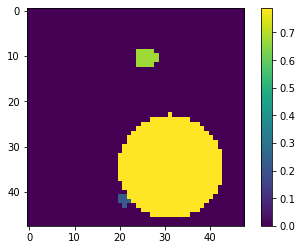

In [25]:
#To plot results from testing examples over the trained model
with torch.no_grad():
    for imageI,imageO in test_dl:
        print(imageI.shape)
        xLW=model(imageI)
        print(xLW.shape)
        RNE=100*torch.linalg.norm(imageO-xLW, ord='fro')/torch.linalg.norm(imageO, ord='fro')
        print(RNE)
        indx=0
        imageR=torch.reshape(imageO[indx,0:N],(Np,Np))
        imageP=torch.reshape(xLW[indx,0:N],(Np,Np))
        plt.imshow(imageR.cpu().data.numpy())
        plt.colorbar()
        break

(<matplotlib.image.AxesImage at 0x225a3ce3490>,
 <matplotlib.colorbar.Colorbar at 0x225a3d11160>)

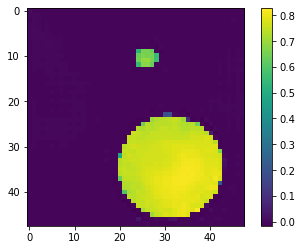

In [26]:
plt.imshow(imageP.cpu().data.numpy()),plt.colorbar()